# Tweets Classifcation Model


In [ ]:
import csv
import matplotlib as matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import pprint as pp
from sklearn.metrics import f1_score
import gc
import os, re, csv, math, codecs
from tqdm import tqdm

# NLP imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import contractions
from bs4 import BeautifulSoup
import unicodedata
import re
from nltk.stem import WordNetLemmatizer
stemmer = WordNetLemmatizer()
from bs4 import BeautifulSoup
import unicodedata
import emoji
import nltk

# Embeddings Imports
from gensim.models.fasttext import FastText
from nltk import WordPunctTokenizer
from textblob import TextBlob

# CNN and MLP Imports
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Input, Dropout, Embedding, GlobalMaxPooling1D, Conv1D, MaxPooling1D, concatenate, Flatten
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras import Model,Sequential
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.layers import Bidirectional,LSTM,GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.callbacks import LearningRateScheduler # Callback Learning Rate Scheduler
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam, Nadam, SGD
from tensorflow.keras.callbacks import EarlyStopping # Callback for early stopping
from tensorflow.keras.callbacks import LearningRateScheduler # Callback for early stopping
from sklearn.model_selection import KFold
from tensorflow import keras
from tensorflow.keras import backend as K # Importing Keras backend (by default it is Tensorflow)
from tensorflow.keras.models import Model # The class used to create a model


print("Tensorflow version " + tf.__version__)

Using TensorFlow backend.


Tensorflow version 2.1.1


### Load Datasets/Word Embeddings

#### Load Datasets

In [ ]:
# Read training data
train_index = list()
Y_train = list()
with open('../data/train.csv', 'r') as f:
    for line in f:
        t = line.split(',')
        train_index.append(int(t[0]))
        Y_train.append(int(t[1]))
# print('Y_train: ',Y_train)

# Read test data
test_index = list()  
with open('../data/test.csv', 'r', encoding='utf8') as f:
    for line in f:
        t = line.split(',')
        test_index.append(int(t[0]))
        
# Load the textual content of the messages into the dictionary "posts"
# Store the ID of the user that posted each message, and initialize for each user a 15-dimensional vector
# that will store the number of messages of each class posted by the user
posts = dict()
posted_by = dict()
posts_per_class = dict()
with open('../data/posts.tsv', 'r', encoding='utf-8', errors='ignore') as f:
    for line in f:
        t = line.split('\t')
        posts[int(t[0])] = t[2][:-1]
        posted_by[int(t[0])] = int(t[1])
        posts_per_class[int(t[1])] = np.zeros(15)
users = list(posted_by.values())

#### Load Pretrained Fastext Embeddings

In [ ]:
#load embeddings
print('loading word embeddings...')
embedding_dict = {}
f = codecs.open('../embeddings/crawl-300d-2M.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = coefs
f.close()
print('found %s word vectors' % len(embedding_dict))

2164it [00:00, 10633.25it/s]

loading word embeddings...


1999996it [03:07, 10670.29it/s]

found 1999996 word vectors


### Data Preprocessing

#### Create training and test set lists of posts

In [ ]:
train_posts = [posts[idx] for idx in train_index]
test_posts = [posts[idx] for idx in test_index]

# Max tweet length berween all data sets
max_list = []
max_list.append(len(max(train_posts, key=len)))
max_list.append(len(max(test_posts, key=len)))
print("The max length of all training and test post is: ", max(max_list))

The max length of all training and test post is:  999


### Data Cleaning 

* Remove @References
* Replace web addresses with "http"
* Replace ips with "IP"
* Counting days feature added in place of quarantine days countdown
* Remove month or replace month to not be considered as stopword
* Replace html tags in ASCII
* Remove of extra newlines that are present in really noisy text
* Demojize - Convert emoticons into their corresponding descriptive label
* Remove accented characters
* Remove Special Characters
* Replace numbers with #s as encoded in embeddings
* Lemmatization
* Stop Word filtering

In [ ]:
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

In [ ]:
def clean_numbers(text):
    if bool(re.search(r'\d', text)):
        text = re.sub('[0-9]{5,}', '#####', text)
        text = re.sub('[0-9]{4}', '####', text)
        text = re.sub('[0-9]{3}', '###', text)
        text = re.sub('[0-9]{2}', '##', text)
    return text

def remove_web_addresses(text):
    HTTP = re.compile("(\w+:\/\/\S+)", flags=re.VERBOSE)
    text = re.sub(HTTP, " http ", text)
    return text

def remove_ip(text):
    # remove IPs or replace them with IP
    IP = re.compile(r"""(?<!\d)[\d*x]{1,3}\.[\d*x]{1,3}\.[\d*x]{1,3}\.[\d*x]{1,3}(?!\d)""", flags=re.IGNORECASE)
    text = re.sub(IP, " IP ", text)
    return text

def remove_month(text):
    # remove month or replace month
    MONTH = re.compile(r"""
    (january|jan|february|feb|march|mar|april|apr|may|june|jun|july|jul|august|aug|september|sep|october|oct|november|nov|december|dec)\s
    """, flags=re.VERBOSE)
    text = re.sub(MONTH, " month ", text)
    
    return text

def counting_days(text):
    DAY = re.compile(r"""
    (day|days)\s*\d{1,2}\s
    |
    (day|days)\s*\d{1,2}[\,/]*\d{1,2}\s
    """, flags=re.VERBOSE)
    text = re.sub(DAY, " counting days ", text)
    
    return text

def remove_hashtags_atreferences(text):
#     text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)", " ", text).split())
    return text

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    [s.extract() for s in soup(['iframe', 'script'])]
    stripped_text = soup.get_text()
    stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
    return stripped_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def expand_contractions(text):
    return contractions.fix(text)

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9.,!?\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

def separate(text):
    # separate full stops, keep consecutive full stops together as there are embeddings for them
    text = re.sub(r"(\.+)", r" \1 ", text)
    # separate ,
    text = re.sub(r",", " , ", text)
    # separate !
    text = re.sub(r"!", " ! ", text)
    # text = re.sub(r"(\!+)", r" \1 ", text)
    # separate ?
    text = re.sub(r"\?", " ? ", text)
    return text

def pre_process_document(document):
    # lower case
    document = document.lower()
    # remove hashtag words and @ref words
    document = remove_hashtags_atreferences(document)
    # remove web addresses
    document = remove_web_addresses(document)
    # remove IP
    document = remove_ip(document)
    # counting days
    document = counting_days(document)
    document = remove_month(document)
    # strip HTML
    document = strip_html_tags(document)
    # remove extra newlines (often might be present in really noisy text)
    document = document.translate(document.maketrans("\n\t\r", "   "))
    # demojize
    document = emoji.demojize(document)
    # remove accented characters
    document = remove_accented_chars(document)
    # expand contractions    
    document = expand_contractions(document)  
    document = remove_special_characters(document, remove_digits=False)
    document = separate(document)
    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = clean_numbers(document)
    document = document.strip()
     # Lemmatization
    tokens = document.split()
    tokens = [stemmer.lemmatize(word) for word in tokens]
    tokens = [word for word in tokens if word not in en_stop]
    tokens = [word for word in tokens if len(word) > 3 or word in ['.',',','!','?','day','uk','usa']]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [ ]:
train_posts = [pre_process_document(post) for post in train_posts]
test_posts = [pre_process_document(post) for post in test_posts]

**Transform posts and labels to required form to feed to network**

In [ ]:
max_words = 23067
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_posts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 23067 unique tokens.


In [ ]:
train_sequences = tokenizer.texts_to_sequences(train_posts)
test_sequences = tokenizer.texts_to_sequences(test_posts)

#### Distribution of length in training posts

* We plot the posts' length distribution to identify the outliers and configure their length. Pad the small posts and limit the large sequences.

In [ ]:
keys = range(0, len(max(train_sequences, key=len))+1)
values = np.zeros(len(max(train_sequences, key=len))+1)
dict_len = dict()
for i, post in enumerate(train_sequences):
    values[len(post)] +=1

distribution = dict(zip(keys, values))
print(distribution)

{0: 5.0, 1: 28.0, 2: 107.0, 3: 219.0, 4: 377.0, 5: 502.0, 6: 622.0, 7: 742.0, 8: 664.0, 9: 484.0, 10: 472.0, 11: 391.0, 12: 388.0, 13: 435.0, 14: 518.0, 15: 615.0, 16: 672.0, 17: 680.0, 18: 831.0, 19: 883.0, 20: 870.0, 21: 820.0, 22: 627.0, 23: 527.0, 24: 354.0, 25: 174.0, 26: 89.0, 27: 68.0, 28: 37.0, 29: 10.0, 30: 5.0, 31: 2.0, 32: 0.0, 33: 0.0, 34: 0.0, 35: 2.0, 36: 1.0}


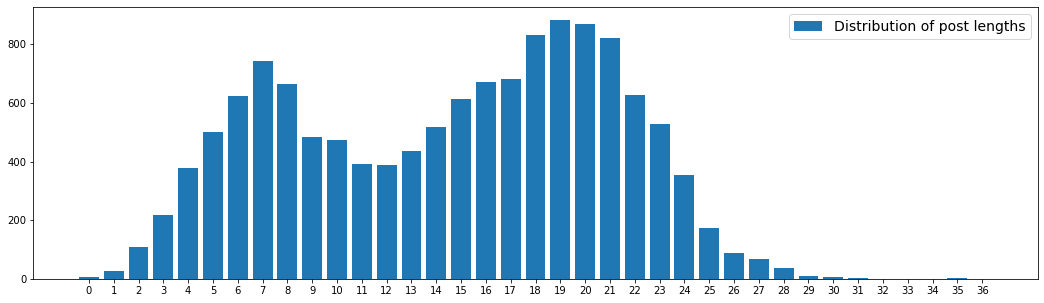

In [ ]:
f, ax = plt.subplots(figsize=(18,5))
plt.bar(range(len(distribution)), list(distribution.values()), align='center', label='Distribution of post lengths')
plt.xticks(range(len(distribution)), list(distribution.keys()))
ax.legend(fontsize = 14)
plt.show()

In [ ]:
# check zero length sequences
count = 0
for i in range (len(train_sequences)):
    if len(train_sequences[i]) == 0:
        count +=1
print("We can count ", count, " zero sequences in training set after pre-processing")

We can count  5  zero sequences in training set after pre-processing


In [ ]:
# CROSS-CHECK initial count of train_sequences 

print(len(train_sequences))
print(len(Y_train))

13221
13221


#### Initialize appropriate parameters

In [ ]:
maxlen = len(max(train_sequences, key=len))
print("The maximun length of all sequences is: ", maxlen, '\n')

embed_size = 300
print("The size of the embeddings vectors is: ", embed_size, '\n')

classes = 15
print("Number of classes: ", classes, '\n')

nb_words = len(word_index)
print("Number of unique tokens: ", nb_words, '\n')

The maximun length of all sequences is:  36 

The size of the embeddings vectors is:  300 

Number of classes:  15 

Number of unique tokens:  23067 



#### Pad sequences and convert Y vectors into one hot vectors

In [ ]:
X_train = pad_sequences(train_sequences, maxlen=maxlen)
X_test = pad_sequences(test_sequences, maxlen=maxlen)
# np.save('../data/X_test_cnn',X_test)

print('Shape of x_train tensor:', X_train.shape)
# print('Shape of Y_train_one_hot tensor:', Y_train_one_hot.shape)

Shape of x_train tensor: (13221, 36)


### Embeddings Engineering

1. Train embeddings on current corpus to replace non represented words in pre-trained model
2. Construct Embedding Matrix:
    * Add word embeddings retieved from the pre-trained embeddings + "TextBlob polarity-subjectivity extra embedding"
    * Add word embedding from trained model + "TextBlob polarity-subjectivity extra embedding" if the word not exists in pre-trained   embeddings


In [ ]:
window_size = 40
min_word = 5
down_sampling = 1e-2

word_punctuation_tokenizer = nltk.WordPunctTokenizer()
word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(sent) for sent in train_posts]

#### Train FastText Model on our corpus

In [ ]:
# Initialization of fastText Model

ft_model = FastText(word_tokenized_corpus,
                      size=embed_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      iter=100)

In [ ]:
# Save fastText trained model
# ft_model.save("../embeddings/model/fasttext.model")

# Load from saved allready created model
ft_model=FastText.load("../embeddings/model/fasttext.model")

In [ ]:
# remove embedding for key='999994' from fastext dictionery because its length is 1 and not 300

embedding_dict.pop('1999995') # fastext crawl removal

array([300.], dtype=float32)

In [ ]:
all_embs = np.stack(embedding_dict.values())
embed_size = all_embs.shape[1]
embed_size = embed_size+2
embedding_matrix = np.zeros((nb_words+1, embed_size))
count_found = nb_words
for word, i in word_index.items():
    embedding_vector = embedding_dict.get(word)
    word_sent = TextBlob(word).sentiment
    # Extra information we are passing to our embeddings
    extra_embed = [word_sent.polarity,word_sent.subjectivity]
    if embedding_vector is not None: 
        embedding_matrix[i] =  np.append(embedding_vector,extra_embed)
    else:
        
        if word.islower():
            embedding_vector = embedding_dict.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = np.append(embedding_vector,extra_embed)
            else:
                embedding_vector_fastext=ft_model.wv[word]
                if embedding_vector_fastext is not None:
                    embedding_matrix[i] = np.append(embedding_vector_fastext,extra_embed)
                else:
                    embedding_matrix[i,300:] = extra_embed
                    count_found-=1
        else:
            embedding_vector_fastext=ft_model.wv[word]
            if embedding_vector_fastext is not None:
                embedding_matrix[i] = np.append(embedding_vector_fastext,extra_embed)
            else:
                embedding_matrix[i,300:] = extra_embed
                count_found-=1
print("Got embedding for ",count_found," words.")

c:\users\myriam.sarantea\pycharmprojects\data_challenge\venv\lib\site-packages\IPython\core\interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


Got embedding for  23067  words.


In [ ]:
print('Shape of embedding matrix:', embedding_matrix.shape)

Shape of embedding matrix: (23068, 302)


### Graph-Based Feature using DeepWalk

In [ ]:
# Store the ID of the user that posted each message
posted_by = dict()
with open('../data/posts.tsv', 'r', encoding="utf8") as f:
    for line in f:
        t = line.split('\t')
        posted_by[int(t[0])] = int(t[1])
        
users = list(posted_by.values())

In [ ]:
import networkx as nx

# Load the processsed retweet network as an undirected graph
G = nx.read_weighted_edgelist("../data/retweet_processed_weighted.edgelist", create_using=nx.Graph(), nodetype=int)
nodes = set(G.nodes())
for user in users:
    if user not in nodes:
        G.add_node(user)

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 12640
Number of edges: 1356575


In [ ]:
from random import randint

def random_walk(G, node, walk_length):
    # Starts from vertex "node" and performs a random walk of length "walk length". Returns a list of the visited vertices
    walk = [node]
    
    for i in range(walk_length-1):
        neighbors = list(G.neighbors(walk[-1]))
        if len(neighbors) > 0:
            next_node = neighbors[randint(0, len(neighbors)-1)]
            walk.append(next_node)
        else:
            break

    walk = [str(node) for node in walk]
    return walk

In [ ]:
def generate_walks(graph, num_walks, walk_length):
    # Runs "num_walks" random walks from each node, and returns a list of all random walk
    walks = []
    
    for i in range (num_walks):
        for node in graph.nodes():
            walks.append(random_walk(graph, node, walk_length))

    return walks

In [ ]:
walks = generate_walks(G, 10, 20)

In [ ]:
print(walks[124])

['15290', '584734', '4218', '468504', '117719', '159409', '54683', '218555', '535847', '277264', '110100', '242007', '2885', '31837', '447045', '26037', '7445', '805', '49036', '4060']


In [ ]:
from gensim.models import Word2Vec

model_w2v = Word2Vec(size=128, window=5, min_count=0, sg=1, workers=8)
model_w2v.build_vocab(walks)
model_w2v.train(walks, total_examples=model_w2v.corpus_count, epochs=5)

(11425900, 11425900)

In [ ]:
X_train_graph = np.zeros((len(train_index), 128))
for i, idx in enumerate(train_index):
    X_train_graph[i, :] = model_w2v.wv[str(posted_by[idx])]


X_test_graph = np.zeros((len(test_index), 128))
for i, idx in enumerate(test_index):
    X_test_graph[i, :] = model_w2v.wv[str(posted_by[idx])]
    
print("Dimensionality of Train matrix: ", X_train_graph.shape)
print("Dimensionality of Test matrix: ", X_test_graph.shape)

Dimensionality of Train matrix:  (13221, 128)
Dimensionality of Test matrix:  (3306, 128)


#### Split in Training and Validation Sets

In [ ]:
# Splitting Train and Validation sets for text and graph features
from sklearn.model_selection import train_test_split
X_tra, X_val, y_tra, y_val = train_test_split(X_train, Y_train, train_size=0.90, random_state=233)
X_tra_graph, X_val_graph, y_tra_graph, y_val_graph = train_test_split(X_train_graph, Y_train, train_size=0.90, random_state=233)

#### Check distribution of Training and Validation set

In [ ]:
class_names = np.arange(15)

In [ ]:
# Distribution of Training Set

dist = np.zeros(classes)
for i in range(len(y_tra)):
    for class_no in range (classes):
        if class_no == y_tra[i]:
            dist[class_no]+=1
dist = dist / len(y_tra) * 100
x= dict(zip(class_names, dist))
print ('Distribution of classes in training set:')
x

Distribution of classes in training set:


{0: 42.519751218692214,
 1: 4.261220373171962,
 2: 18.171121196839803,
 3: 10.665658093797276,
 4: 8.03496385947218,
 5: 1.3531685997646663,
 6: 0.7060010085728694,
 7: 0.13447638258530847,
 8: 0.9413346780971592,
 9: 0.8404773911581778,
 10: 3.7737434863002184,
 11: 2.378551016977643,
 12: 2.2272650865691714,
 13: 1.554883173642629,
 14: 2.437384434358716}

In [ ]:
# Distribution of Validation Set

dist = np.zeros(classes)
for i in range(len(y_val)):
    for class_no in range (classes):
        if class_no == y_val[i]:
            dist[class_no]+=1
dist = dist / len(y_val) * 100
y= dict(zip(class_names, dist))
print ('Distribution of classes in Validation set:')
y

Distribution of classes in Validation set:


{0: 42.55479969765684,
 1: 4.988662131519274,
 2: 16.250944822373395,
 3: 9.901738473167045,
 4: 8.238851095993953,
 5: 1.436130007558579,
 6: 0.7558578987150416,
 7: 0.15117157974300832,
 8: 0.7558578987150416,
 9: 0.9826152683295541,
 10: 3.9304610733182166,
 11: 3.0990173847316704,
 12: 2.5699168556311416,
 13: 1.6628873771730914,
 14: 2.7210884353741496}

In [ ]:
# Convert to one-hot vectors

Y_val_one_hot = to_categorical(y_val, classes)
Y_val_graph_one_hot = to_categorical(y_val_graph, classes)
Y_tra_one_hot = to_categorical(y_tra, classes)
Y_tra_graph_one_hot = to_categorical(y_tra_graph, classes)

In [ ]:
# Save data for ensemble model

np.save('../data/X_val_cnn.npy', X_val)
np.save('../data/Y_val.npy', Y_val_one_hot)
np.save('../data/X_val_deepwlk.npy', X_val_graph)

np.save('../data/X_test_cnn.npy', X_test)
np.save('../data/X_test_deepwlk.npy', X_test_graph)

### Create CNN 1D Model for Text-Based Features

In [ ]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [ ]:
def plot_history(hs, epochs, metric):
    print()
    plt.rcParams['figure.figsize'] = [15, 8]
    plt.rcParams['font.size'] = 16
    plt.clf()
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 2))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()

In [ ]:
# Test if GPU is available
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


In [ ]:
FILTERS = 128
DENSE = 256
filter_sizes = [2,3,4]
optimizer = Nadam(learning_rate=0.0005)

def get_model():
    with tf.device('/device:GPU:0'):

        inputs = Input(shape=(maxlen,), name='input', dtype="int32")
        # Embeddings
        embeddings = Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix],
          input_length=maxlen, trainable=False, name='embedding')(inputs)
        # Dropout over Embeddings
        dropped_embeddings = Dropout(rate=0.1, name='embedding_dropout')(embeddings)
         # Multi-filter CNNs
        concat_pooled_convs = []
        FILTERS = 124
        for n_gram in filter_sizes:
            # n-gram convolutions with padding
            convs = Conv1D(filters=FILTERS, kernel_size=n_gram, strides=1, 
                          padding="same", activation='relu', 
                          name='{}-gram_Convolutions'.format(n_gram))(dropped_embeddings)
            # Max-Pooling over time
            max_tensor = GlobalMaxPooling1D(name='{}-gram_MaxPool'.format(n_gram))(convs)
            concat_pooled_convs.append(max_tensor)

        concat = concatenate(concat_pooled_convs, name='concatenate')
        concat = Dropout(rate=0.5, name='dropout')(concat)
        outputs = Dense(classes, activation='softmax', name='output_layer')(concat)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(loss = 'categorical_crossentropy',
                    optimizer = optimizer,
                    metrics = ['accuracy'])
#         plot_model(model, to_file='cnn_architecture.png', show_shapes=True, show_layer_names=True)
        return model
model = get_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 36)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 36, 302)      6966536     input[0][0]                      
__________________________________________________________________________________________________
embedding_dropout (Dropout)     (None, 36, 302)      0           embedding[0][0]                  
__________________________________________________________________________________________________
2-gram_Convolutions (Conv1D)    (None, 36, 124)      75020       embedding_dropout[0][0]          
____________________________________________________________________________________________

#### Train with validation split, Early Stopping and Decreasing Decay

In [ ]:
batch_size = 256
epochs = 50

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# This function keeps the learning rate at 0.001 for the first five epochs
# and decreases it exponentially after that.

# def scheduler(epoch):
#     if epoch < 6:
#         return 0.001
#     else:
#         return 0.001 * tf.math.exp(0.1 * (7 - epoch))

# lrScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

hist = model.fit(X_tra, Y_tra_one_hot, batch_size=batch_size, epochs=epochs,
                 validation_data=(X_val, Y_val_one_hot),verbose=1,
                callbacks=[early_stopping]) # , lrScheduler

Train on 11898 samples, validate on 1323 samples
Epoch 1/50
11898/11898 [==============================] - 3s 288us/sample - loss: 2.0575 - accuracy: 0.3884 - val_loss: 1.6074 - val_accuracy: 0.5351
Epoch 2/50
11898/11898 [==============================] - 3s 232us/sample - loss: 1.5798 - accuracy: 0.5244 - val_loss: 1.4143 - val_accuracy: 0.5782
Epoch 3/50
11898/11898 [==============================] - 3s 231us/sample - loss: 1.3864 - accuracy: 0.5797 - val_loss: 1.2981 - val_accuracy: 0.6100
Epoch 4/50
11898/11898 [==============================] - 3s 232us/sample - loss: 1.2503 - accuracy: 0.6168 - val_loss: 1.2200 - val_accuracy: 0.6228
Epoch 5/50
11898/11898 [==============================] - 3s 232us/sample - loss: 1.1646 - accuracy: 0.6419 - val_loss: 1.1749 - val_accuracy: 0.6349
Epoch 6/50
11898/11898 [==============================] - 3s 232us/sample - loss: 1.0943 - accuracy: 0.6617 - val_loss: 1.1380 - val_accuracy: 0.6531
Epoch 7/50
11898/11898 [===========================

In [ ]:
# Save cnn Model

filename = '../classification_models/model_cnn.h5'
model.save(filename)
print('>Saved %s' % filename)

>Saved ../classification_models/model_cnn.h5


### Evaluation

Train Loss     : 0.32930
Validation Loss: 1.01133
---
Train Accuracy     : 0.90343
Validation Accuracy: 0.70899



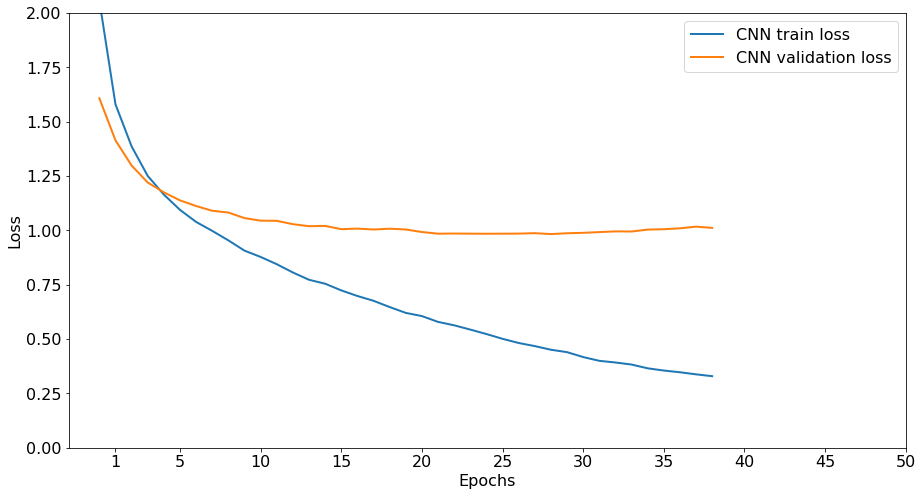

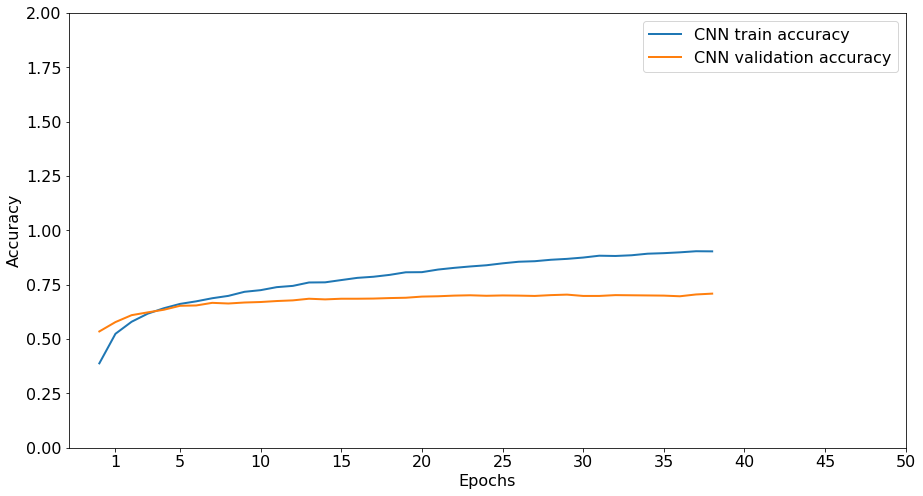

In [ ]:
print("Train Loss     : {0:.5f}".format(hist.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(hist.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(hist.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(hist.history['val_accuracy'][-1]))


# Plot train and validation error per epoch.
plot_history(hs={'CNN': hist}, epochs=epochs, metric='loss')
plot_history(hs={'CNN': hist}, epochs=epochs, metric='accuracy')

* As we can see from the training and validation plots the gap between the two indicates that the model is overfitting. For this reason we will train with K-Fold Cross Validation to prevent overffitting.

#### K-Fold Cross Validation

In [ ]:
batch_size = 128
epochs = 10
num_folds = 8

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Merge inputs and targets
inputs = np.concatenate((X_tra, X_val), axis=0)
targets = np.concatenate((Y_tra_one_hot, Y_val_one_hot), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):  
    kfold_model = get_model()
    history = kfold_model.fit(inputs[train], targets[train], batch_size=batch_size, epochs=epochs,verbose=1)
    # Generate generalization metrics
    scores = kfold_model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {kfold_model.metrics_names[0]} of {scores[0]}; {kfold_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')
    


Train on 11568 samples
Epoch 1/10
11568/11568 [==============================] - 4s 370us/sample - loss: 1.4688 - accuracy: 0.5590
Epoch 2/10
11568/11568 [==============================] - 3s 243us/sample - loss: 1.0441 - accuracy: 0.6747
Epoch 3/10
11568/11568 [==============================] - 3s 243us/sample - loss: 0.9176 - accuracy: 0.7107
Epoch 4/10
11568/11568 [==============================] - 3s 242us/sample - loss: 0.8307 - accuracy: 0.7395
Epoch 5/10
11568/11568 [==============================] - 3s 242us/sample - loss: 0.7585 - accuracy: 0.7626 - loss: 0.7589 - accuracy: 
Epoch 6/10
11568/11568 [==============================] - 3s 243us/sample - loss: 0.7084 - accuracy: 0.7759
Epoch 7/10
11568/11568 [==============================] - 3s 243us/sample - loss: 0.6486 - accuracy: 0.7948
Epoch 8/10
11568/11568 [==============================] - 3s 244us/sample - loss: 0.6027 - accuracy: 0.8118
Epoch 9/10
11568/11568 [==============================] - 3s 243us/sample - loss: 0.5

11569/11569 [==============================] - 3s 245us/sample - loss: 0.5461 - accuracy: 0.8270
Epoch 10/10
11569/11569 [==============================] - 3s 243us/sample - loss: 0.5071 - accuracy: 0.8429
Score for fold 7: loss of 0.994082450722378; accuracy of 71.61017060279846%
Train on 11569 samples
Epoch 1/10
11569/11569 [==============================] - 3s 293us/sample - loss: 1.4463 - accuracy: 0.5644
Epoch 2/10
11569/11569 [==============================] - 3s 242us/sample - loss: 1.0365 - accuracy: 0.6750
Epoch 3/10
11569/11569 [==============================] - 3s 243us/sample - loss: 0.9011 - accuracy: 0.7115
Epoch 4/10
11569/11569 [==============================] - 3s 245us/sample - loss: 0.8219 - accuracy: 0.7352
Epoch 5/10
11569/11569 [==============================] - 3s 245us/sample - loss: 0.7485 - accuracy: 0.7613
Epoch 6/10
11569/11569 [==============================] - 3s 243us/sample - loss: 0.6841 - accuracy: 0.7824
Epoch 7/10
11569/11569 [=======================

#### Predict on Test set

In [ ]:
# Predict on test set

y_pred_cnn = model.predict(X_test)

In [ ]:
clean_up(model)

### MLP Model for graph-based features

#### Training Phase

In [ ]:
def train_model(
        train_data,
        train_labels,
        optimizer,
        epochs=100,
        batch_size=128, 
        hidden_layers=0,
        hidden_activation='relu',
        output_activation='softmax',
        callbacks=None,
        verbose=1):
    
    np.random.seed(1990) # Define the seed for numpy to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(128,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
        x = Dense(
            units=256,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}'.format(i + 1)
        )(x)
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='glorot_uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_tra_graph,
        y=Y_tra_graph_one_hot,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    plot_model(model, to_file='mlp_architecture.png', show_shapes=True, show_layer_names=True)
    return model, hs

In [ ]:
# Choose epochs
epochs = 150

# Choose batch size
batch_size = 256

# Using Adam
optimizer = Adam(lr=0.0001)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    verbose=1,
    restore_best_weights=True
)


mlp_model, hs_mlp_model = train_model(
    train_data=X_tra_graph,
    train_labels=Y_tra_graph_one_hot,
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=3,
    hidden_activation='relu',
    output_activation='softmax',
    callbacks=[early_stopping]
)


# Evaluate on validation data and show all the results.
mlp_model_eval = mlp_model.evaluate(X_val_graph, Y_val_graph_one_hot, verbose=1)

Train on 10708 samples, validate on 1190 samples
Epoch 1/150
10708/10708 [==============================] - 0s 42us/sample - loss: 2.5424 - accuracy: 0.3449 - val_loss: 2.2587 - val_accuracy: 0.4269
Epoch 2/150
10708/10708 [==============================] - 0s 16us/sample - loss: 2.0036 - accuracy: 0.4392 - val_loss: 1.7945 - val_accuracy: 0.4521
Epoch 3/150
10708/10708 [==============================] - 0s 15us/sample - loss: 1.7020 - accuracy: 0.5161 - val_loss: 1.6035 - val_accuracy: 0.5353
Epoch 4/150
10708/10708 [==============================] - 0s 15us/sample - loss: 1.5550 - accuracy: 0.5489 - val_loss: 1.5130 - val_accuracy: 0.5479
Epoch 5/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.4785 - accuracy: 0.5609 - val_loss: 1.4642 - val_accuracy: 0.5563
Epoch 6/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.4248 - accuracy: 0.5638 - val_loss: 1.4271 - val_accuracy: 0.5580
Epoch 7/150
10708/10708 [==========================

Epoch 55/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.0655 - accuracy: 0.6599 - val_loss: 1.2121 - val_accuracy: 0.6176
Epoch 56/150
10708/10708 [==============================] - 0s 15us/sample - loss: 1.0607 - accuracy: 0.6617 - val_loss: 1.2113 - val_accuracy: 0.6210
Epoch 57/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.0592 - accuracy: 0.6619 - val_loss: 1.2159 - val_accuracy: 0.6151
Epoch 58/150
10708/10708 [==============================] - 0s 15us/sample - loss: 1.0602 - accuracy: 0.6612 - val_loss: 1.2196 - val_accuracy: 0.6067
Epoch 59/150
10708/10708 [==============================] - 0s 15us/sample - loss: 1.0549 - accuracy: 0.6647 - val_loss: 1.2123 - val_accuracy: 0.6244
Epoch 60/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.0530 - accuracy: 0.6645 - val_loss: 1.2202 - val_accuracy: 0.6126
Epoch 61/150
10708/10708 [==============================] - 0s 16us/sample - loss: 1.0488 - ac

In [ ]:
# Save Model
filename = '../classification_models/model_mlp_deepwalk.h5'
mlp_model.save(filename)
print('>Saved %s' % filename)

>Saved ../classification_models/model_mlp_deepwalk.h5


#### Prediction on test set

In [ ]:
y_pred_graph = mlp_model.predict(X_test_graph)

In [ ]:
clean_up(model=mlp_model)

### Averaging Ensemble Model

In [ ]:
y_pred = np.mean((y_pred_cnn, y_pred_graph), axis=0 )

### Export Submission File

In [ ]:
# Write predictions to a file
with open('../submissions/combined_results.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = ['id']
    for i in range(15):
        lst.append('class_'+str(i))
    writer.writerow(lst)
    for i,idx in enumerate(test_index):
        lst = y_pred[i,:].tolist()
        lst.insert(0, idx)
        writer.writerow(lst)